In [1]:
from AudioDataset import AudioDataset
from torch.utils.data import DataLoader
from model_helper import *

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using CUDA device for GPU acceleration.")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using MPS device for GPU acceleration.")
else:
    device = torch.device("cpu")
    print("No GPU device found. Using CPU.")

Using CUDA device for GPU acceleration.


In [3]:
import random

random.seed(42)
torch.manual_seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    
classes = ["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go", "silence", "unknown"]

In [4]:
class AudioTransformer(nn.Module):
    def __init__(self, n_mels=80, n_classes=12, d_model=128, nhead=4, num_layers=2, dim_feedforward=256):
        super(AudioTransformer, self).__init__()
        self.input_proj = nn.Linear(n_mels, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, x):
        x = self.input_proj(x)
        transformer_out = self.transformer_encoder(x)
        x = transformer_out.mean(dim=1)
        out = self.classifier(x)
        return out

In [5]:
train_dataset = AudioDataset(
    csv_path="./data/train_balanced.csv",
    audio_dir="./data_raw/train/audio"
)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True)

In [6]:
test_dataset = AudioDataset(
    csv_path="./data/test.csv",
    audio_dir="./data_raw/train/audio"
)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, drop_last=True)

Epoch 1, Loss: 2.0340
Epoch 2, Loss: 1.4365
Epoch 3, Loss: 1.1483
Epoch 4, Loss: 0.9438
Epoch 5, Loss: 0.8135
Epoch 6, Loss: 0.7261
Epoch 7, Loss: 0.6636
Epoch 8, Loss: 0.6121
Epoch 9, Loss: 0.5730
Epoch 10, Loss: 0.5414
Epoch 11, Loss: 0.5153
Epoch 12, Loss: 0.4878
Epoch 13, Loss: 0.4706
Epoch 14, Loss: 0.4489
Epoch 15, Loss: 0.4349
Epoch 16, Loss: 0.4195
Epoch 17, Loss: 0.4060
Epoch 18, Loss: 0.3912
Epoch 19, Loss: 0.3815
Epoch 20, Loss: 0.3693
Accuracy of the network transformer with lr = 0.0001 and weight decay = 0: 73.64%
Accuracy of class "yes": 93.75%
Accuracy of class "no": 81.35%
Accuracy of class "up": 92.65%
Accuracy of class "down": 83.79%
Accuracy of class "left": 88.01%
Accuracy of class "right": 83.01%
Accuracy of class "on": 86.18%
Accuracy of class "off": 81.68%
Accuracy of class "stop": 93.98%
Accuracy of class "go": 82.07%
Accuracy of class "silence": 93.02%
Accuracy of class "unknown": 65.60%
Epoch 1, Loss: 1.4251
Epoch 2, Loss: 1.0379
Epoch 3, Loss: 1.2281
Epoch 4,

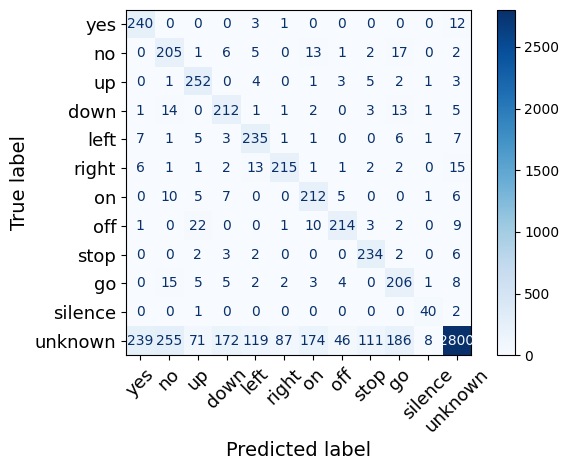

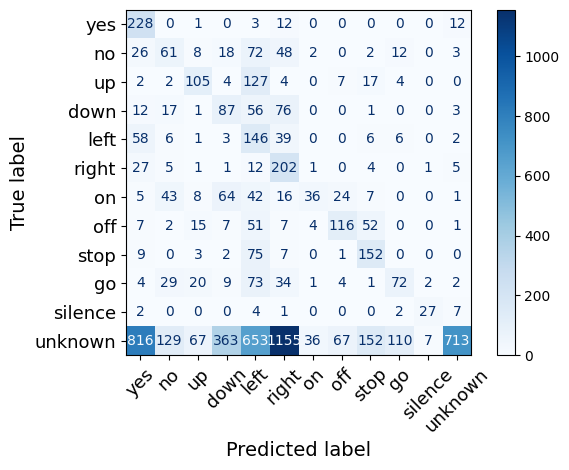

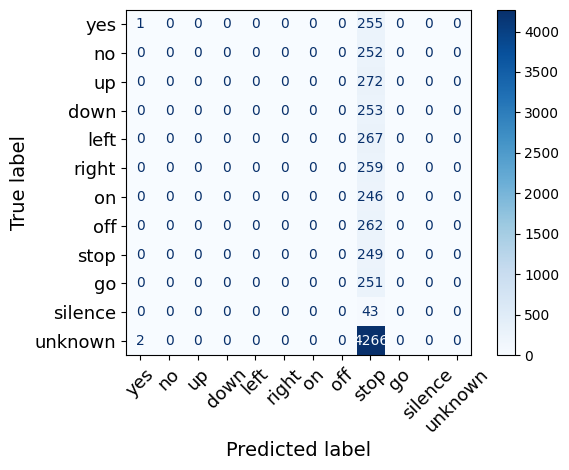

In [7]:
learning_rate_values = [0.0005, 0.001, 0.005, 0.01]
weight_decay = 0 #default value
model_name = 'transformer'
tested_parameter = 'lr'
epoch_number = 20

for lr in learning_rate_values:
    model = AudioTransformer().to(device)
    model = train_model(model, device, train_dataloader, lr=lr, weight_decay=weight_decay, model_name=model_name, epoch_number=epoch_number, save_flg = True)
    predict_model(model, device, classes, test_loader, lr=lr, weight_decay=weight_decay, model_name=model_name, tested_parameter=tested_parameter, save_flg = True)

In [ ]:
weight_decay_values = [0.0005,0.001,0.005,0.01]
lr = 0.0005
model_name = 'transformer'
tested_parameter = 'weight_decay'
epoch_number = 20

for weight_decay in weight_decay_values:
    model = AudioTransformer().to(device)
    model = train_model(model, device, train_dataloader, lr=lr, weight_decay=weight_decay, model_name=model_name, epoch_number=epoch_number, save_flg = True)
    predict_model(model, device, classes, test_loader, lr=lr, weight_decay=weight_decay, model_name=model_name, tested_parameter=tested_parameter, save_flg = True)